In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Camp_Market_Cleaned = pd.read_csv("Camp_Market_Cleaned.csv")

df = Camp_Market_Cleaned
df.columns = df.columns.str.strip()

df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Last_Purchase,MntWines,MntFruits,MntMeatProducts,...,Z_CostContact,Z_Revenue,Response,Customer_For_Months,Childrens,Family_Size,Total_Spent,Total_Purchases,Age,Age_group
0,5524,1957,Graduate,Single,58138,04/09/2012,58,635,88,546,...,3,11,1,159,0,1,1617,25,59,50-59
1,2174,1954,Graduate,Single,46344,08/03/2014,38,11,1,6,...,3,11,0,141,2,3,27,6,62,60-69
2,4141,1965,Graduate,Couple,71613,21/08/2013,26,426,49,127,...,3,11,0,148,0,2,776,21,51,50-59
3,6182,1984,Graduate,Couple,26646,10/02/2014,26,11,4,20,...,3,11,0,142,1,3,53,8,32,30-39
4,5324,1981,Postgrad,Couple,58293,19/01/2014,94,173,43,118,...,3,11,0,143,1,3,422,19,35,30-39


In [ ]:


lower_map = {c.lower(): c for c in df.columns}
def has(col): return col.lower() in lower_map
def col(col): return lower_map.get(col.lower())
 
today = pd.Timestamp.today().normalize()
 
if has("Year_Birth"):
    df["age"] = today.year - pd.to_numeric(df[col("Year_Birth")], errors="coerce")
elif any(has(x) for x in ["DOB","DateOfBirth","BirthDate","date_naissance"]):
    birth_col = next(lower_map[k] for k in lower_map if k in {"dob","dateofbirth","birthdate","date_naissance"})
    dob = pd.to_datetime(df[birth_col], errors="coerce", dayfirst=True)
    df["age"] = (today - dob).dt.days // 365
elif has("age"):
    df["age"] = pd.to_numeric(df[col("age")], errors="coerce")
else:
    df["age"] = np.nan
 
classic_spend_cols = ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]
present_spend_cols = [col(c) for c in classic_spend_cols if has(c)]
if not present_spend_cols:
    present_spend_cols = [lower_map[c] for c in lower_map
                          if ("mnt" in c or "spent" in c or "purchase_amount" in c)
                          and c not in {"acceptedcmp1","acceptedcmp2","acceptedcmp3","acceptedcmp4","acceptedcmp5","response"}]
df["spent"] = df[present_spend_cols].select_dtypes(include=[np.number]).sum(axis=1) if present_spend_cols else np.nan
 
mcol = next((col(c) for c in ["Marital_Status","MaritalStatus","marital","statut_matrimonial"] if has(c)), None)
def normalize_marital(x):
    if not isinstance(x, str): return "alone"
    x = x.strip().lower()
    partner_vals = {"married","together","union","relationship","couple","companion","compagnon"}
    single_vals = {"single","divorced","widow","widowed","separated","célibataire","divorcé","veuf","veuve"}
    if any(v in x for v in partner_vals): return "partner"
    if any(v in x for v in single_vals):  return "alone"
    return "alone"
if mcol:
    df["living_with"] = df[mcol].map(normalize_marital)
elif has("Partner"):
    df["living_with"] = np.where(df[col("Partner")].astype(bool), "partner", "alone")
else:
    df["living_with"] = "alone"
 
if has("Kidhome") or has("Teenhome"):
    kids = pd.to_numeric(df[col("Kidhome")], errors="coerce").fillna(0) if has("Kidhome") else 0
    teens = pd.to_numeric(df[col("Teenhome")], errors="coerce").fillna(0) if has("Teenhome") else 0
    df["children"] = kids + teens
elif any(has(x) for x in ["Children","Enfants","NbrChildren","NbEnfants"]):
    ccol = next(lower_map[k] for k in lower_map if k in {"children","enfants","nbrchildren","nbenfants"})
    df["children"] = pd.to_numeric(df[ccol], errors="coerce").fillna(0)
else:
    df["children"] = 0
 
df["family_size"] = 1 + (df["living_with"].eq("partner")).astype(int) + df["children"].astype(int)
df["is_parent"] = df["children"].astype(int) > 0
 
ecol = next((col(c) for c in@ ["Education","education","NiveauEtude","Niveau_Etude"] if has(c)), None)
def map_edu(e):
    if not isinstance(e, str): return "Other"
    x = e.strip().lower()
    if any(k in x for k in ["phd","master","postgrad"]): return "Postgraduate"
    if any(k in x for k in ["graduation","graduate","licence","bachelor","2n cycle","engineer","ingénieur"]): return "Graduate"
    if any(k in x for k in ["undergrad","diploma","bac+2","dut","bts"]): return "Undergraduate"
    if "basic" in x or "second" in x or "lycée" in x or "high school" in x: return "Basic"
    return "Other"
df["education2"] = df[ecol].map(map_edu) if ecol else "Other"
 
dcol = next((col(c) for c in ["Dt_Customer","DateCustomer","CustomerSince","Date_Inscription","dt_customer"] if has(c)), None)
if dcol:
    joined = pd.to_datetime(df[dcol], errors="coerce", dayfirst=True, infer_datetime_format=True)
    df["customer_for"] = (today - joined).dt.days / 365.25
else:
    df["customer_for"] = np.nan
 
idcol = next((col(c) for c in ["ID","Id","CustomerID","ClientID","id_client","id"] if has(c)), None)
df = df.drop_duplicates(subset=[idcol]) if idcol else df.drop_duplicates()
 
accept_cols = [c for c in df.columns if c.lower().startswith("acceptedcmp") or c.lower() == "response"]
df_accept = df[accept_cols].apply(pd.to_numeric, errors="coerce").fillna(0) if accept_cols else pd.DataFrame()
campaign_rates = (df_accept.mean().sort_values(ascending=False) if not df_accept.empty else pd.Series(dtype=float))
 

claim_col = next((c for c in df.columns if c.lower() in {"complain","claim","reclamation","has_claim"}), None)
claim_rate = float(pd.to_numeric(df[claim_col], errors="coerce").fillna(0).astype(int).mean()*100) if claim_col else np.nan
 
print("Variables créées :", ["age","spent","living_with","children","family_size","is_parent","education2","customer_for"])
if not campaign_rates.empty:
    print("\nTaux de succès par campagne (%) :")
    print((campaign_rates*100).round(2))
    print("\nCampagne la plus réussie :", campaign_rates.idxmax(), f"({campaign_rates.max()*100:.2f}%)")
else:
    print("\nAucune colonne de campagne trouvée (AcceptedCmp* / Response).")
 
if not np.isnan(claim_rate):
    print(f"\n% de clients ayant porté claim : {claim_rate:.2f}%")
else:
    print("\nAucune colonne de claim trouvée (Complain / Claim).")
 
if not campaign_rates.empty:
    plt.figure(figsize=(9,5))
    (campaign_rates*100).plot(kind="bar")
    plt.title("Taux de succès par campagne")
    plt.ylabel("Taux de succès (%)")
    plt.xlabel("Campagne")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
 
if not np.isnan(claim_rate):
    plt.figure(figsize=(5,5))
    plt.pie([claim_rate, 100-claim_rate],
            labels=["Claim","No Claim"],
            autopct="%.1f%%",
            startangle=90)
    plt.title("% de clients ayant porté claim")
    plt.tight_layout()
    plt.show()
 
 
 
 

SyntaxError: invalid syntax (1432138071.py, line 66)

In [ ]:

print("="*60)
print("CAMPAIGN EFFECTIVENESS (Response)")
print("="*60)

if 'Response' in df.columns:
    total = len(df)
    yes = df['Response'].fillna(0).astype(int).sum()
    rate = 100 * yes / total
    print(f"Overall response rate: {rate:.1f}%  ({yes}/{total})")

    for col in ['Age_group', 'Education', 'Marital_Status']:
        if col in df.columns:
            rates = (df.groupby(col)['Response']
                       .mean()
                       .mul(100)
                       .sort_values(ascending=False))
            print(f"\nResponse rate by {col}:")
            for k, v in rates.items():
                print(f"  {k:20s} : {v:5.1f}%")
else:
    print("Column 'Response' not found.")

CAMPAIGN EFFECTIVENESS (Response)
Overall response rate: 14.9%  (303/2039)

Response rate by Age_group:
  70-79                :  20.6%
  30-39                :  16.7%
  20-29                :  15.5%
  60-69                :  15.2%
  40-49                :  14.7%
  50-59                :  12.5%
  100+                 :   0.0%

Response rate by Education:
  Postgrad             :  18.1%
  Graduate             :  13.6%
  Undergrad            :   9.8%

Response rate by Marital_Status:
  Single               :  21.9%
  Couple               :  10.9%


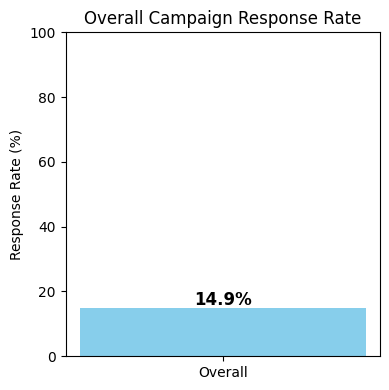

In [ ]:

if 'Response' in df.columns:
    total = len(df)
    yes = df['Response'].fillna(0).astype(int).sum()
    rate = 100 * yes / total

    plt.figure(figsize=(4,4))
    plt.bar(['Overall'], [rate], color='skyblue')
    plt.title("Overall Campaign Response Rate")
    plt.ylabel("Response Rate (%)")

    plt.text(0, rate + 1, f"{rate:.1f}%", ha='center', fontsize=12, fontweight='bold')

    plt.ylim(0, max(100, rate + 10))
    plt.tight_layout()
    plt.show()
else:
    print("Column 'Response' not found.")

import matplotlib.pyplot as plt


Response Rate by Education:
Education
Postgrad     18.1
Graduate     13.6
Undergrad     9.8


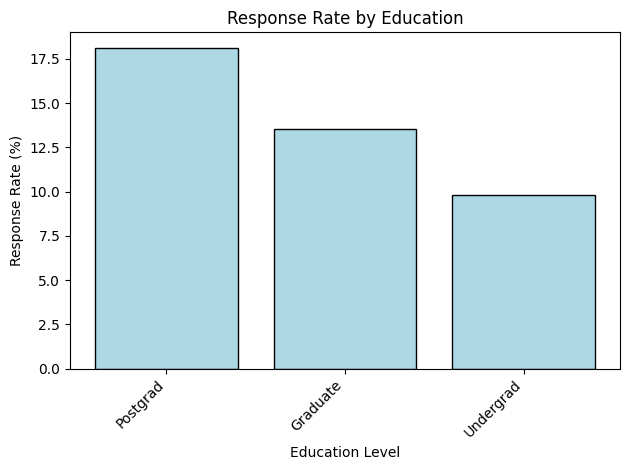

In [ ]:
rates = df.groupby('Education')['Response'].mean().mul(100).sort_values(ascending=False)

print("Response Rate by Education:")
print(rates.round(1).to_string())

plt.bar(rates.index, rates.values, color='lightblue', edgecolor='black')
plt.title("Response Rate by Education")
plt.ylabel("Response Rate (%)")
plt.xlabel("Education Level")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*60)
print("CUSTOMER ENGAGEMENT")
print("="*60)

if 'Total_Purchases' in df.columns:
    engaged = (df['Total_Purchases'] > 0).sum()
    print(f"Engaged customers (>=1 purchase): {engaged} / {len(df)} "
          f"({100*engaged/len(df):.1f}%)")

    bins = [0,1,5,10,20,50, np.inf]
    labels = ["0","1-5","6-10","11-20","21-50","50+"]
    purch_bin = pd.cut(df['Total_Purchases'], bins=bins, labels=labels, right=True)
    dist = purch_bin.value_counts().reindex(labels).fillna(0)
    print("\nTotal purchases distribution:")
    for k, v in dist.items():
        print(f"  {k:6s}: {int(v)} customers")
else:
    print("Column 'Total_Purchases' not found.")


CUSTOMER ENGAGEMENT
Engaged customers (>=1 purchase): 2035 / 2039 (99.8%)

Total purchases distribution:
  0     : 4 customers
  1-5   : 250 customers
  6-10  : 494 customers
  11-20 : 735 customers
  21-50 : 552 customers
  50+   : 0 customers


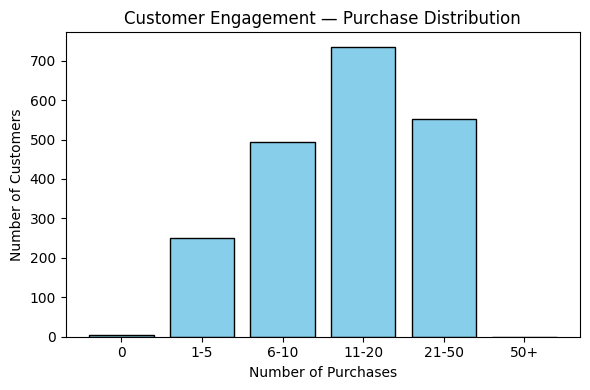

In [ ]:

if 'Total_Purchases' in df.columns:
   
    bins = [0, 1, 5, 10, 20, 50, np.inf]
    labels = ["0", "1-5", "6-10", "11-20", "21-50", "50+"]
    dist = pd.cut(df['Total_Purchases'], bins=bins, labels=labels).value_counts().sort_index()

    plt.figure(figsize=(6,4))
    plt.bar(dist.index.astype(str), dist.values, color='skyblue', edgecolor='black')

    plt.title("Customer Engagement — Purchase Distribution")
    plt.xlabel("Number of Purchases")
    plt.ylabel("Number of Customers")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'Total_Purchases' not found.")


In [ ]:

print("\n" + "="*60)
print("RESPONDERS VS NON-RESPONDERS")
print("="*60)

if 'Response' in df.columns:
    responders = df[df['Response'] == 1]
    nonresp    = df[df['Response'] == 0]

    def mean_safe(s): 
        return float(s.mean()) if len(s) else np.nan

    for col, label in [('Total_Spent','Avg spend'),
                       ('Income','Avg income'),
                       ('Age','Avg age')]:
        if col in df.columns:
            m_r  = mean_safe(responders[col])
            m_nr = mean_safe(nonresp[col])
            if not (np.isnan(m_r) or np.isnan(m_nr)):
                diff = m_r - m_nr
                print(f"{label}: responders={m_r:,.0f} | non-responders={m_nr:,.0f} | diff={diff:,.0f}")

else:
    print("Column 'Response' not found.")



RESPONDERS VS NON-RESPONDERS
Avg spend: responders=985 | non-responders=540 | diff=445
Avg income: responders=60,174 | non-responders=50,974 | diff=9,199
Avg age: responders=47 | non-responders=47 | diff=-1


In [ ]:
print("\n" + "="*60)
print("SIMPLE SEGMENTATION (by Total_Spent & Income)")
print("="*60)

seg_series = None
if {'Total_Spent','Income'}.issubset(df.columns):
    ts = df['Total_Spent']
    inc = df['Income']

    condlist = [
        (ts > 1000) & (inc > 60000),
        (ts > 500),
        (ts > 100)
    ]
    choicelist = ["VIP", "Good customer", "Average customer"]
    seg_series = np.select(condlist, choicelist, default="Small buyer")

    seg_counts = pd.Series(seg_series).value_counts()
    print("Segment split:")
    for seg, n in seg_counts.items():
        print(f"  {seg:17s}: {n:4d} customers ({100*n/len(df):4.1f}%)")

    print("\nSegment profiles:")
    for seg in ["VIP","Good customer","Average customer","Small buyer"]:
        mask = (seg_series == seg)
        if mask.sum() == 0:
            continue
        print(f"\n  {seg.upper()}")
        if 'Income' in df:       print(f"    Avg income     : {df.loc[mask,'Income'].mean():>8,.0f}")
        if 'Total_Spent' in df:  print(f"    Avg spend      : {df.loc[mask,'Total_Spent'].mean():>8,.0f}")
        if 'Age' in df:          print(f"    Avg age        : {df.loc[mask,'Age'].mean():>8.1f}")
        if 'Response' in df:     print(f"    Response rate  : {100*df.loc[mask,'Response'].mean():>8.2f}%")
else:
    print("Need columns 'Total_Spent' and 'Income' for segmentation.")




SIMPLE SEGMENTATION (by Total_Spent & Income)
Segment split:
  Small buyer      :  650 customers (31.9%)
  VIP              :  499 customers (24.5%)
  Average customer :  484 customers (23.7%)
  Good customer    :  406 customers (19.9%)

Segment profiles:

  VIP
    Avg income     :   76,601
    Avg spend      :    1,484
    Avg age        :     48.6
    Response rate  :    29.46%

  GOOD CUSTOMER
    Avg income     :   61,250
    Avg spend      :      811
    Avg age        :     49.9
    Response rate  :    11.08%

  AVERAGE CUSTOMER
    Avg income     :   45,770
    Avg spend      :      277
    Avg age        :     47.9
    Response rate  :    13.22%

  SMALL BUYER
    Avg income     :   33,047
    Avg spend      :       49
    Avg age        :     44.1
    Response rate  :     7.23%


In [ ]:
print("\n" + "="*60)
print("RESPONSIVE CUSTOMERS SNAPSHOT")
print("="*60)

if 'Response' in df.columns:
    r = df[df['Response'] == 1]
    print(f"\nResponders: {len(r)}")
    if len(r):
        if 'Income' in r:      print(f"  Avg income : {r['Income'].mean():,.0f}")
        if 'Total_Spent' in r: print(f"  Avg spend  : {r['Total_Spent'].mean():,.0f}")
        if 'Age' in r:         print(f"  Avg age    : {r['Age'].mean():.1f}")
        mnt_cols = [c for c in df.columns if c.startswith('Mnt')]
        if mnt_cols:
            top5 = r[mnt_cols].mean().sort_values(ascending=False).head(5)
            print("\n  Top 5 spend categories (mean):")
            for k, v in top5.items():
                print(f"    {k:20s}: {v:,.0f}")



RESPONSIVE CUSTOMERS SNAPSHOT

Responders: 303
  Avg income : 60,174
  Avg spend  : 985
  Avg age    : 46.6

  Top 5 spend categories (mean):
    MntWines            : 496
    MntMeatProducts     : 297
    MntGoldProds        : 63
    MntFishProducts     : 51
    MntFruits           : 39



CHARTS


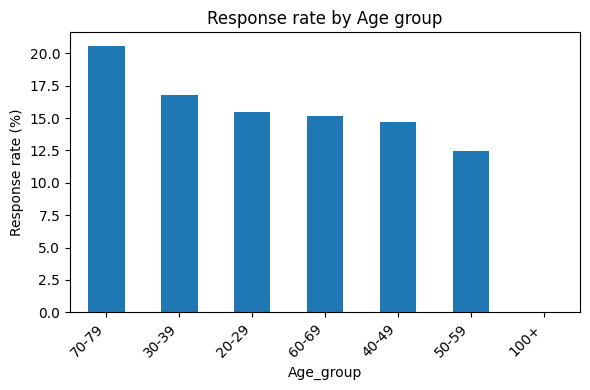

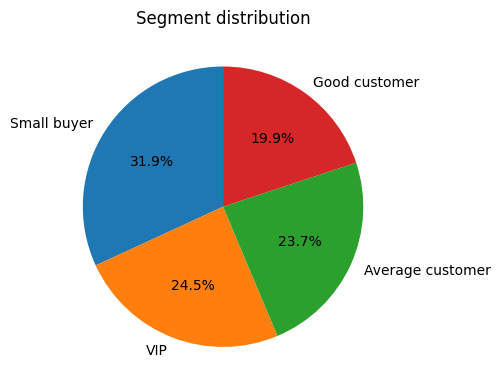

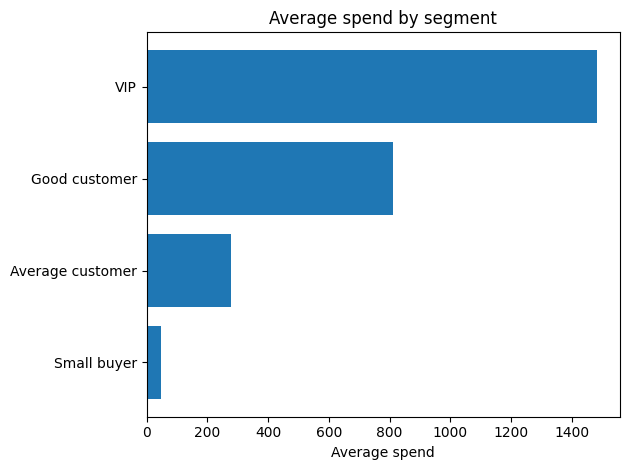

In [ ]:
print("\n" + "="*60)
print("CHARTS")
print("="*60)

if {'Response','Age_group'}.issubset(df.columns):
    (df.groupby('Age_group')['Response'].mean().mul(100)
       .sort_values(ascending=False)).plot(kind='bar', figsize=(6,4))
    plt.title("Response rate by Age group")
    plt.ylabel("Response rate (%)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if seg_series is not None:
    pd.Series(seg_series).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(5,5))
    plt.title("Segment distribution")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

if seg_series is not None and 'Total_Spent' in df.columns:
    order = ["Small buyer","Average customer","Good customer","VIP"]
    means = [df.loc[seg_series==s, 'Total_Spent'].mean() if (seg_series==s).any() else np.nan for s in order]
    plt.barh(order, means)
    plt.title("Average spend by segment")
    plt.xlabel("Average spend")
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

if 'Response' in df.columns and seg_series is not None:
    seg_resp = pd.Series({
        s: df.loc[seg_series==s, 'Response'].mean() 
        for s in np.unique(seg_series)
        if (seg_series==s).any()
    }).sort_values(ascending=False)
    best_seg = seg_resp.index[0] if len(seg_resp) else None
else:
    best_seg = None

best_age = None
if {'Response','Age_group'}.issubset(df.columns):
    age_resp = df.groupby('Age_group')['Response'].mean().sort_values(ascending=False)
    best_age = age_resp.index[0] if len(age_resp) else None

if best_seg: print(f"1) Prioritize segment: {best_seg} (highest response rate).")
if best_age: print(f"2) Tailor messaging to {best_age} (most responsive age group).")
if 'Response' in df.columns and 'Total_Spent' in df.columns:
    d1 = df.loc[df['Response']==1, 'Total_Spent'].mean()
    d0 = df.loc[df['Response']==0, 'Total_Spent'].mean()
    if pd.notna(d1) and pd.notna(d0):
        print(f"3) Responders spend on average {d1 - d0:,.0f} more than non-responders.")

print("\n" + "="*60)
print("DONE")
print("="*60)


RECOMMENDATIONS
1) Prioritize segment: VIP (highest response rate).
2) Tailor messaging to 70-79 (most responsive age group).
3) Responders spend on average 445 more than non-responders.

DONE


In [ ]:
spend = df['Total_Spent']
resp  = df['Response']

spend_seg = pd.qcut(spend, 4, labels=['Q1-Low','Q2-Mid','Q3-High','Q4-Top'])

resp_by_seg = df.groupby(spend_seg)['Response'].mean().mul(100).round(1)
count_by_seg = df.groupby(spend_seg)['Response'].size()

print("="*60)
print("KPI 2 — Response Rate by Customer Value (Spend Segments)")
print("="*60)
for seg in resp_by_seg.index:
    print(f"{seg:8s}: {resp_by_seg[seg]:>5.1f}%  (n={count_by_seg[seg]})")

KPI 2 — Response Rate by Customer Value (Spend Segments)
Q1-Low  :   5.3%  (n=510)
Q2-Mid  :  12.5%  (n=511)
Q3-High :  11.6%  (n=508)
Q4-Top  :  30.0%  (n=510)


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_43760/3979565299.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resp_by_seg = df.groupby(spend_seg)['Response'].mean().mul(100).round(1)
/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_43760/3979565299.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_seg = df.groupby(spend_seg)['Response'].size()


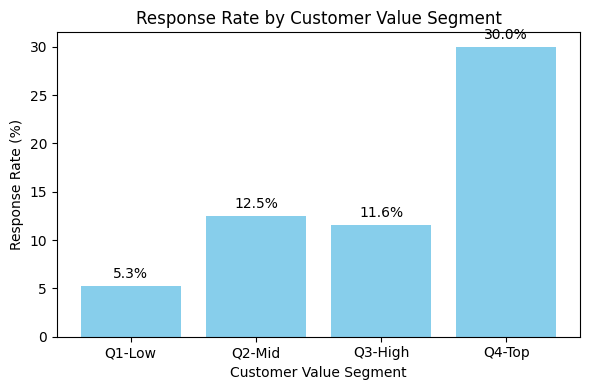

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(resp_by_seg.index, resp_by_seg.values, color='skyblue')

plt.title("Response Rate by Customer Value Segment")
plt.ylabel("Response Rate (%)")
plt.xlabel("Customer Value Segment")

for i, v in enumerate(resp_by_seg.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*60)
print("KPI 3 — Customer Lifetime Value (proxy) & Behavior")
print("="*60)

has_recency = 'Last_Purchase' in df.columns
metrics = {
    'Avg CLV (Total_Spent)': df['Total_Spent'].mean(),
    'Avg Frequency (Total_Purchases)': df['Total_Purchases'].mean(),
}
if has_recency:
    metrics['Avg Recency (Last_Purchase)'] = df['Last_Purchase'].mean()

for k, v in metrics.items():
    print(f"{k:32s}: {v:,.2f}")

print("\nBy spend segment:")
groupers = [spend_seg]
agg_dict = {'Total_Spent':'mean','Total_Purchases':'mean'}
if has_recency:
    agg_dict['Last_Purchase'] = 'mean'

seg_stats = df.groupby(groupers).agg(agg_dict)
seg_stats.columns = [ 
    'Avg CLV (Total_Spent)' if c=='Total_Spent' else
    'Avg Frequency' if c=='Total_Purchases' else
    'Avg Recency' for c in seg_stats.columns
]
print(seg_stats.round(2).to_string())



KPI 3 — Customer Lifetime Value (proxy) & Behavior
Avg CLV (Total_Spent)           : 605.87
Avg Frequency (Total_Purchases) : 14.86
Avg Recency (Last_Purchase)     : 49.10

By spend segment:
             Avg CLV (Total_Spent)  Avg Frequency  Avg Recency
Total_Spent                                                   
Q1-Low                       39.14           5.96        48.93
Q2-Mid                      186.62          11.02        48.84
Q3-High                     707.36          20.65        48.91
Q4-Top                     1491.58          21.83        49.71


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_43760/1819234203.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_stats = df.groupby(groupers).agg(agg_dict)


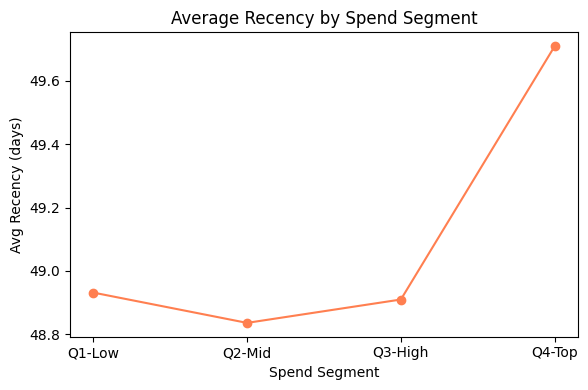

In [37]:
if 'Avg Recency' in seg_stats.columns:
    plt.figure(figsize=(6,4))
    plt.plot(seg_stats.index, seg_stats['Avg Recency'], marker='o', color='coral')
    plt.title("Average Recency by Spend Segment")
    plt.ylabel("Avg Recency (days)")
    plt.xlabel("Spend Segment")
    plt.tight_layout()
    plt.show()


In [ ]:
print("\n" + "="*60)
print("KPI 4 — Average Order Value (AOV)")
print("="*60)

purchases_pos = df['Total_Purchases'] > 0
overall_aov = df.loc[purchases_pos, 'Total_Spent'].sum() / df.loc[purchases_pos, 'Total_Purchases'].sum()
print(f"Overall AOV: {overall_aov:,.2f}")

aov_by_seg = (
    df.loc[purchases_pos]
      .groupby(spend_seg[purchases_pos])
      .apply(lambda g: g['Total_Spent'].sum() / g['Total_Purchases'].sum())
      .round(2)
)
print("\nAOV by spend segment:")
for seg, val in aov_by_seg.items():
    print(f"{str(seg):8s}: {val:,.2f}")


KPI 4 — Average Order Value (AOV)
Overall AOV: 40.77

AOV by spend segment:
Q1-Low  : 6.56
Q2-Mid  : 16.93
Q3-High : 34.25
Q4-Top  : 68.32


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_43760/224801341.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(spend_seg[purchases_pos])


In [ ]:
resp_by_seg = df.groupby(spend_seg)['Response'].mean().mul(100).round(1)

has_recency = 'Last_Purchase' in df.columns
agg = {'Total_Spent':'mean','Total_Purchases':'mean'}
if has_recency:
    agg['Last_Purchase'] = 'mean'
seg_stats = df.groupby(spend_seg).agg(agg)

mask = df['Total_Purchases'] > 0
overall_aov = (
    df.loc[mask, 'Total_Spent'].sum() /
    df.loc[mask, 'Total_Purchases'].sum()
)
aov_by_seg = (
    df.loc[mask]
      .groupby(spend_seg)
      .apply(lambda g: g['Total_Spent'].sum() / g['Total_Purchases'].sum())
)


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_43760/2623089155.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resp_by_seg = df.groupby(spend_seg)['Response'].mean().mul(100).round(1)
/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_43760/2623089155.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_stats = df.groupby(spend_seg).agg(agg)
/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_43760/2623089155.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

In [ ]:
print(f"Overall response rate: {df['Response'].mean()*100:.1f}%")
print("Response by value segment (%):")
print(resp_by_seg.to_string())
print(f"\nOverall AOV: {overall_aov:,.2f}")

Overall response rate: 14.9%
Response by value segment (%):
Total_Spent
Q1-Low      5.3
Q2-Mid     12.5
Q3-High    11.6
Q4-Top     30.0

Overall AOV: 40.77
